In [106]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import distance_matrix
import warnings
warnings.simplefilter(action='ignore')

In [84]:
df = pd.read_csv("/Users/lidouhao/Documents/GitHub/Captone_depression/00_data/02_intermediate/20241031agg_smart_chr.csv")
gdf = gpd.read_file("/Users/lidouhao/Documents/GitHub/Captone_depression/00_data/01_raw/tl_2024_us_cbsa/tl_2024_us_cbsa.shp")

In [88]:
gdf['cbsacode'] = gdf['GEOID']

In [19]:
# Reproject to a suitable projected CRS
gdf = gdf.to_crs("EPSG:5070") 

# Calculate centroids 
gdf['centroid'] = gdf['geometry'].centroid

# Create a new GeoDataFrame for centroids and reproject to WGS84 (latitude/longitude)
centroids = gdf.set_geometry('centroid').to_crs("EPSG:4326")

# Extract latitude and longitude from centroids
gdf['latitude'] = centroids.geometry.y
gdf['longitude'] = centroids.geometry.x

df['cbsacode'] = df['cbsacode'].astype(str)

In [21]:
df_loc = df.merge(gdf[['latitude','longitude','cbsacode']],how='left')

In [100]:

def preprocess_factor_data(data, year, factor_column, population_column, method='per_capita'):
    # Filter data for the specified year and drop rows with missing values in required columns
    data = data[(data['year'] == year) & 
                data[[factor_column, population_column]].notna().all(axis=1)].copy()
    
    if method == 'per_capita':
        # Calculate per capita factor and return as NumPy array
        data[f'{factor_column}_per_capita'] = data[factor_column] / data[population_column]
        return data[f'{factor_column}_per_capita'].to_numpy(), data['cbsacode'].to_numpy()
    
    elif method == 'SAMI':
        # Log-transform population and factor values
        data['log_population'] = np.log(data[population_column])
        data['log_factor'] = np.log(data[factor_column])
        
        # Fit the scaling model using OLS (log-log regression)
        model = smf.ols('log_factor ~ log_population', data=data).fit()
        
        # Calculate SAMI and return as NumPy array
        intercept = model.params['Intercept']
        slope = model.params['log_population']
        data['SAMI'] = data['log_factor'] - (slope * data['log_population'] + intercept)
        
        return data['SAMI'].to_numpy(), data['cbsacode'].to_numpy()
    
    else:
        raise ValueError("Method must be either 'per_capita' or 'SAMI'")

def calculate_distance_matrix(cbsacodes, gdf):
    """
    Calculate the adjacency matrix based on CBSA codes.
    :param cbsacodes: Numpy array of CBSA codes.
    :param gdf: GeoDataFrame with CBSA codes and geometries.
    :return: Adjacency matrix as a NumPy array.
    """
    # Filter and sort gdf by CBSA codes to ensure consistent order
    gdf_filtered = gdf[gdf['cbsacode'].isin(cbsacodes)].set_index('cbsacode').loc[cbsacodes]
    
    n = len(gdf_filtered)
    adjacency_matrix = np.zeros((n, n), dtype=int)

    # Iterate over each pair of geometries to check adjacency
    for i in range(n):
        for j in range(n):
            if i != j and gdf_filtered.geometry.iloc[i].touches(gdf_filtered.geometry.iloc[j]):
                adjacency_matrix[i, j] = 1  # Mark as adjacent
    return adjacency_matrix

def morans_i(values, weights_matrix):
    # Check dimensions of values and weights_matrix
    if weights_matrix.shape[0] != len(values) or weights_matrix.shape[1] != len(values):
        raise ValueError("Mismatch between weights matrix dimensions and values size.")
    
    n = len(values)
    mean_value = np.mean(values)
    S0 = np.sum(weights_matrix)
    denominator = np.sum((values - mean_value) ** 2)
    
    numerator = 0
    for i in range(n):
        for j in range(n):
            numerator += weights_matrix[i, j] * (values[i] - mean_value) * (values[j] - mean_value)
            
    return (n / S0) * (numerator / denominator)

def calculate_morans_i_for_factors(data, year, factor_columns, population_column, gdf, method='per_capita'):
    """
    Calculate Moran's I for multiple factors and store results in a DataFrame.
    
    :param data: DataFrame containing the factors, population, CBSA code, and year columns.
    :param year: The specific year to filter data on.
    :param factor_columns: List of column names for the factors to be preprocessed.
    :param population_column: Column name of the population data.
    :param gdf: GeoDataFrame with CBSA codes and geometries.
    :param method: Preprocessing method, either 'per_capita' or 'SAMI'.
    :return: DataFrame with factors and their corresponding Moran's I values.
    """
    
    # Store results in a dictionary for easy conversion to a DataFrame later
    results = {}

    # Iterate over each factor to preprocess, calculate a unique adjacency matrix, and calculate Moran's I
    for factor_column in factor_columns:
        # Preprocess data for the current factor
        values, cbsa = preprocess_factor_data(data, year, factor_column, population_column, method=method)
        
        # Calculate a unique adjacency matrix for the current factor based on available CBSA codes
        weights_matrix = calculate_distance_matrix(cbsa, gdf)
        
        # Calculate Moran's I
        moran_i_value = morans_i(values, weights_matrix)
        
        # Add the result to the dictionary
        results[factor_column] = [moran_i_value]
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [107]:
factors = ['total_adult_obesity',
       'total_adult_smoking', 'total_children_in_poverty',
       'total_children_in_single-parent_households',
       'total_excessive_drinking', 'total_homicides',
       'total_mental_health_providers', 'total_motor_vehicle_crash_deaths',
       'total_not_proficient_in_english', 'total_physical_inactivity',
       'total_poor_or_fair_health', 'total_premature_death',
       'total_primary_care_physicians', 'total_rural',
       'total_sexually_transmitted_infections', 'total_uninsured_adults',
       'total_violent_crime', 'total_poor_physical_health_days',
       'total_poor_mental_health_days',
       'Park_Area_Acres', 'Weighted_RESP', 'noise4050n', 'noise5060n',
       'noise6070n', 'noise7080n', 'noise8090n', 'noise90n']

all_results = []

# Loop through each year and calculate Moran's I results
for year in range(2011, 2022):
    morans_i_results = calculate_morans_i_for_factors(df_loc, year, factors, 'population', gdf, method='per_capita')
    morans_i_results['year'] = year  # Add year column
    all_results.append(morans_i_results)

# Concatenate all yearly results into a single DataFrame
combined_results_capita = pd.concat(all_results).reset_index()

In [108]:
combined_results_capita

,index,total_adult_obesity,total_adult_smoking,total_children_in_poverty,total_children_in_single-parent_households,total_excessive_drinking,total_homicides,total_mental_health_providers,total_motor_vehicle_crash_deaths,total_not_proficient_in_english,...,total_poor_mental_health_days,Park_Area_Acres,Weighted_RESP,noise4050n,noise5060n,noise6070n,noise7080n,noise8090n,noise90n,year
0,0,0.804288,0.705678,0.523690,0.520052,0.397137,0.625397,0.633626,0.679882,0.588721,...,0.136131,-0.044028,0.378915,0.016306,-0.012350,-0.036484,0.039183,0.017903,-0.150450,2011
1,0,0.585165,0.644792,0.480833,0.467080,0.414473,0.461480,0.501012,0.666917,0.448665,...,0.079723,-0.026833,0.134386,-0.012329,-0.016247,-0.047235,0.063510,0.027347,-0.300094,2012
2,0,0.589561,0.566595,0.544023,0.338802,0.504912,0.403763,0.676651,0.943710,0.359579,...,0.279080,0.000920,0.256920,-0.000562,-0.017115,-0.059488,0.048310,0.009982,-0.232132,2013
3,0,0.560258,0.497311,0.470309,0.378116,0.596852,0.475889,NaN,1.150803,0.241998,...,0.277936,0.004405,0.212906,-0.005320,-0.001790,0.010799,0.127481,0.026458,-0.470697,2014
4,0,0.629127,0.563693,0.455222,0.450625,0.589417,0.498712,1.052302,0.998492,0.353845,...,0.262515,0.007580,0.227054,-0.093080,-0.074661,-0.051564,0.042021,-0.016062,-0.614506,2015
5,0,0.614365,0.733545,0.482432,0.385025,0.600130,0.417303,1.021454,1.017094,0.416718,...,0.340927,-0.003389,0.257277,-0.050775,-0.042951,-0.046530,0.062602,-0.001454,-0.388628,2016
6,0,0.482280,0.603442,0.339349,0.324643,0.461542,0.405996,0.997727,1.046973,0.308400,...,0.371616,0.005780,0.264042,-0.023310,-0.017558,-0.027638,0.067223,0.007368,-0.337503,2017
7,0,0.668088,0.713417,0.426754,0.402281,0.550555,0.518854,1.077174,0.916982,0.402870,...,0.292609,-0.004705,0.202041,-0.097122,-0.055592,-0.093078,0.016168,-0.010463,-0.331940,2018
8,0,0.819633,1.059003,0.553045,0.537418,0.670276,0.561474,1.067231,0.807932,0.468760,...,0.256801,-0.057602,0.163711,-0.069580,-0.039843,-0.076006,0.023268,0.041526,-0.212861,2019
9,0,0.632083,0.780012,0.561396,0.470682,0.643809,0.533845,1.074977,0.923663,0.186327,...,0.389199,-0.004703,0.179193,-0.147520,-0.092807,-0.071761,0.053028,-0.008844,-0.486152,2020


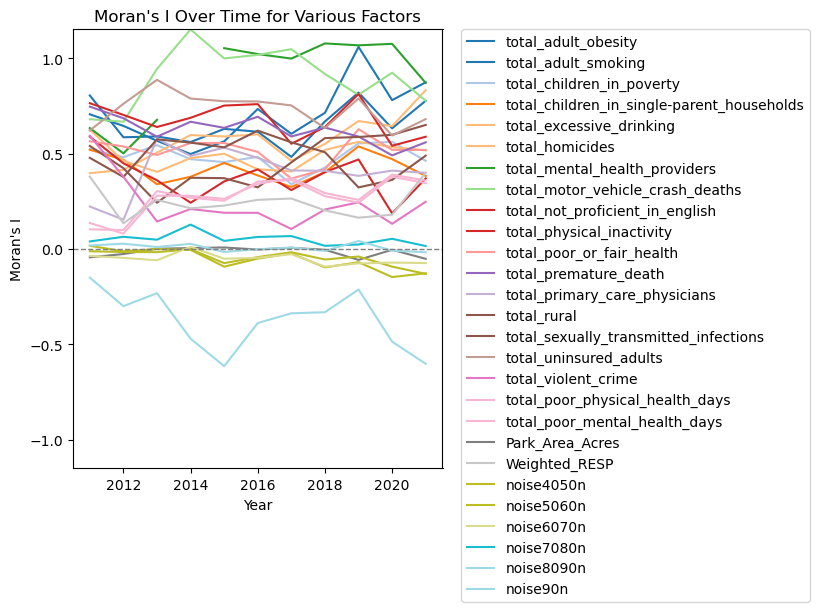

In [114]:

import matplotlib.cm as cm

# Set up the figure size
plt.figure(figsize=(10, 6))
colors = cm.get_cmap('tab20', len(factors))

# Find the y-axis limits to ensure all plots use the same range
y_min = combined_results_capita[factors].min().min()
y_max = combined_results_capita[factors].max().max()
y_range = max(abs(y_min), abs(y_max))  # Use the max absolute value for symmetry around zero

# Plot each factor with the same y-axis limits and unique colors from the colormap
for i, factor in enumerate(factors):
    plt.plot(combined_results_capita['year'], combined_results_capita[factor], label=factor, color=colors(i))

# Add a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# Set y-axis limits to be symmetric around zero
plt.ylim(-y_range, y_range)

# Label the axes and set title
plt.xlabel('Year')
plt.ylabel("Moran's I")
plt.title("Moran's I Over Time for Various Factors")

# Place the legend outside the plot on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [105]:
combined_results_SAMI

,index,total_adult_obesity,total_adult_smoking,total_children_in_poverty,total_children_in_single-parent_households,total_excessive_drinking,total_homicides,total_mental_health_providers,total_motor_vehicle_crash_deaths,total_not_proficient_in_english,...,total_poor_mental_health_days,Park_Area_Acres,Weighted_RESP,noise4050n,noise5060n,noise6070n,noise7080n,noise8090n,noise90n,year
0,0,0.803813,0.808248,0.668777,0.549249,0.427392,NaN,0.485577,0.738368,0.419946,...,0.462959,0.069655,0.554022,0.035002,0.056155,0.030385,NaN,NaN,NaN,2011
1,0,0.601671,0.700123,0.740625,0.529566,0.387691,NaN,0.487377,0.763521,0.285286,...,0.456720,0.076898,0.427536,-0.001775,0.017391,-0.074770,0.030822,0.027815,0.244194,2012
2,0,0.530145,0.652438,0.576079,0.393379,0.482029,NaN,0.493636,0.793741,0.297036,...,0.370708,0.047998,0.586837,0.099603,0.050258,-0.101640,-0.083913,NaN,NaN,2013
3,0,0.497993,0.596823,0.559314,0.423503,0.556212,NaN,NaN,0.955537,0.281529,...,0.344515,0.074176,0.678449,0.015325,0.086203,-0.026837,0.084159,0.066665,0.249114,2014
4,0,0.576534,0.645638,0.479103,0.487717,0.537688,NaN,0.827452,0.824053,0.305388,...,0.339096,0.101530,0.625097,-0.097571,-0.055511,-0.179753,-0.132459,-0.097096,0.082324,2015
5,0,0.560885,0.820903,0.560647,0.435309,0.649342,NaN,0.808092,0.824197,0.301873,...,0.428107,0.034911,0.633684,0.084715,0.036953,-0.116007,-0.079775,NaN,NaN,2016
6,0,0.414124,0.649319,0.397959,0.344293,0.474953,NaN,0.795709,0.815428,0.246282,...,0.474350,0.061260,0.626524,0.118133,0.078604,-0.084640,-0.074879,NaN,NaN,2017
7,0,0.612331,0.745420,0.512376,0.436430,0.547669,NaN,0.861730,0.788458,0.355624,...,0.469984,0.059423,0.618492,-0.099474,-0.030559,-0.126075,-0.000913,NaN,NaN,2018
8,0,0.914519,1.315616,0.600903,0.612331,0.705750,NaN,0.912737,0.866772,0.427868,...,0.459583,-0.185452,0.640405,-0.039263,0.002192,-0.073884,0.008214,NaN,NaN,2019
9,0,0.562737,0.777625,0.585658,0.486536,0.597476,NaN,0.897588,0.739875,0.286972,...,0.364973,0.033235,0.479256,-0.100349,-0.021263,-0.099740,0.021698,-0.010279,0.070893,2020


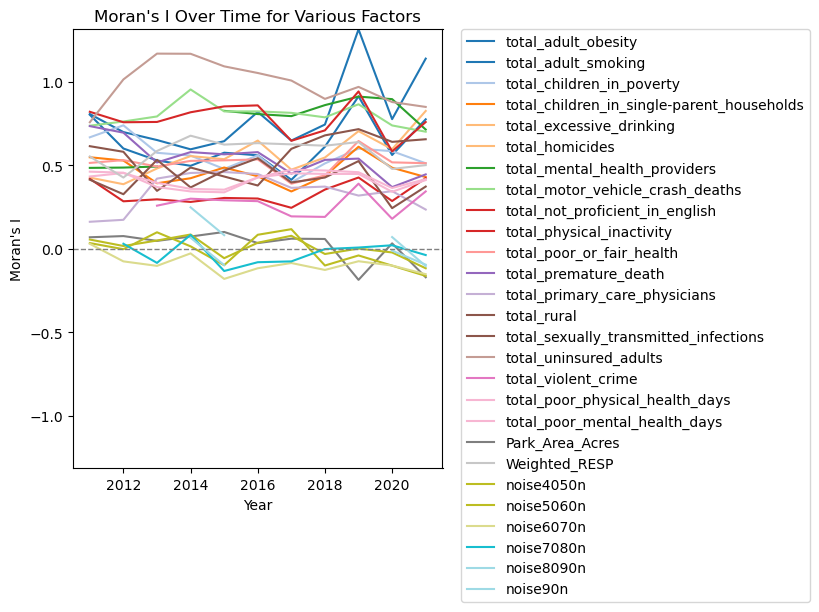

In [115]:

import matplotlib.cm as cm

# Set up the figure size
plt.figure(figsize=(10, 6))
colors = cm.get_cmap('tab20', len(factors))

# Find the y-axis limits to ensure all plots use the same range
y_min = combined_results_SAMI[factors].min().min()
y_max = combined_results_SAMI[factors].max().max()
y_range = max(abs(y_min), abs(y_max))  # Use the max absolute value for symmetry around zero

# Plot each factor with the same y-axis limits and unique colors from the colormap
for i, factor in enumerate(factors):
    plt.plot(combined_results_SAMI['year'], combined_results_SAMI[factor], label=factor, color=colors(i))

# Add a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# Set y-axis limits to be symmetric around zero
plt.ylim(-y_range, y_range)

# Label the axes and set title
plt.xlabel('Year')
plt.ylabel("Moran's I")
plt.title("Moran's I Over Time for Various Factors")

# Place the legend outside the plot on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [121]:
df_loc['depression'] = df_loc['Data_value'] * df_loc['population'] / 100
df_loc['d2'] = df_loc['depression_twitter19'] * df_loc['CENSUS2019POP']
df_loc['d3'] = df_loc['depression_twitter10'] * df_loc['CENSUS2010POP']

In [124]:
all_results

[   depression    Dataset
 0    0.392936  BRFSS2011,
    depression    Dataset
 0    0.425048  BRFSS2012,
    depression    Dataset
 0    0.343692  BRFSS2013,
    depression    Dataset
 0    0.405194  BRFSS2014,
    depression    Dataset
 0     0.38008  BRFSS2015,
    depression    Dataset
 0    0.265535  BRFSS2016,
    depression    Dataset
 0    0.011778  BRFSS2017,
    depression    Dataset
 0    0.280111  BRFSS2018,
    depression    Dataset
 0    0.317406  BRFSS2019,
    depression    Dataset
 0     0.25148  BRFSS2020,
    depression    Dataset
 0    0.165297  BRFSS2021]

In [140]:
all_results = []
for year in range(2011, 2022):
    morans_i_results = calculate_morans_i_for_factors(df_loc, year, ['depression'], 'population', gdf, method='SAMI')
    morans_i_results['Dataset'] = "BRFSS" + str(year)
    all_results.append(morans_i_results)
    
morans_10 = calculate_morans_i_for_factors(df_loc, 2011, ['d3'], 'CENSUS2010POP', gdf, method='SAMI')
morans_10['depression'] = morans_10['d3']
morans_10['Dataset'] = "Twitter10"
all_results.append(morans_10[['depression','Dataset']])

morans_19 = calculate_morans_i_for_factors(df_loc, 2019, ['d2'], 'CENSUS2019POP', gdf, method='SAMI')
morans_19['depression'] = morans_19['d2']
morans_19['Dataset'] = "Twitter19"
all_results.append(morans_19[['depression','Dataset']])

# Concatenate all yearly results into a single DataFrame
SAMI_depression = pd.concat(all_results).reset_index()

In [134]:
SAMI_depression

,index,depression,Dataset
0,0,0.392936,BRFSS2011
1,0,0.425048,BRFSS2012
2,0,0.343692,BRFSS2013
3,0,0.405194,BRFSS2014
4,0,0.380080,BRFSS2015
5,0,0.265535,BRFSS2016
6,0,0.011778,BRFSS2017
7,0,0.280111,BRFSS2018
8,0,0.317406,BRFSS2019
9,0,0.251480,BRFSS2020


In [138]:
capita_depression

,index,depression,Dataset
0,0,0.476882,BRFSS2011
1,0,0.583458,BRFSS2012
2,0,0.427333,BRFSS2013
3,0,0.594819,BRFSS2014
4,0,0.487691,BRFSS2015
5,0,0.448091,BRFSS2016
6,0,0.232251,BRFSS2017
7,0,0.455717,BRFSS2018
8,0,0.469243,BRFSS2019
9,0,0.490462,BRFSS2020
